In [1]:
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt("example_data/count_data.csv")
n_count_data = len(count_data)

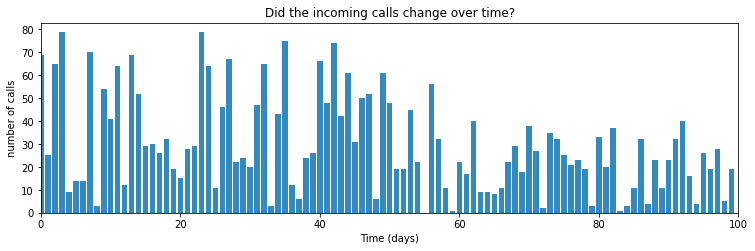

In [3]:
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("number of calls")
plt.title("Did the incoming calls change over time?")
plt.xlim(0, n_count_data);


In [4]:
alpha = 1.0/count_data.mean()
days = np.arange(0, n_count_data)
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    rate = pm.math.switch(tau >= days, lambda_1, lambda_2)
    # Likelihood (sampling distribution) of observations
    observation = pm.Poisson("observation", rate, observed=count_data)

In [5]:
with basic_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


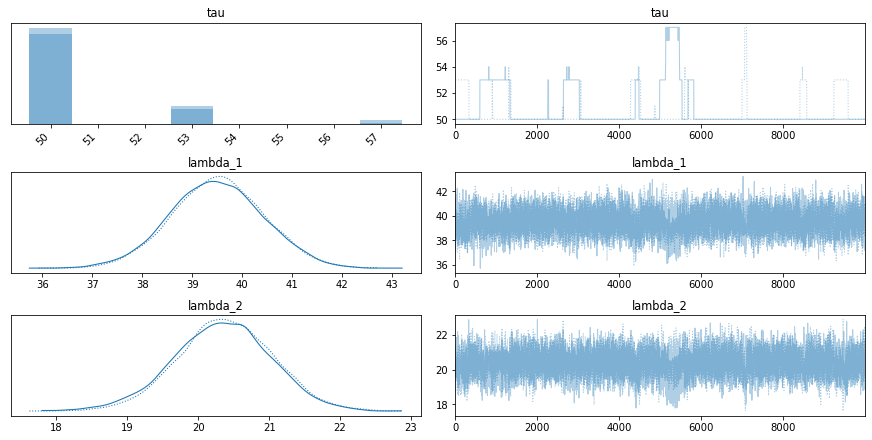

In [6]:
with basic_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "tau":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

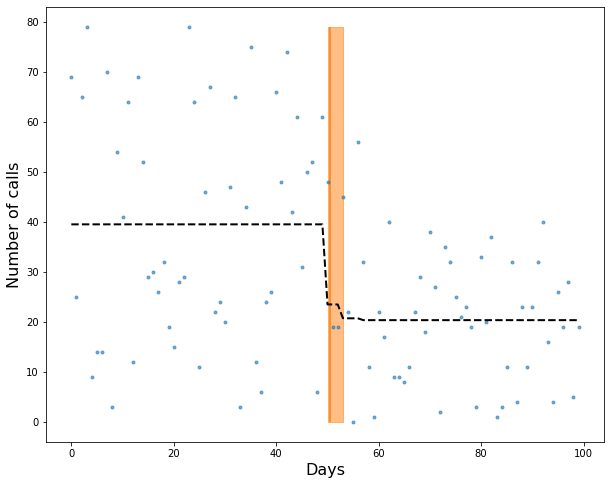

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(days, count_data, ".", alpha=0.6)
plt.ylabel("Number of calls", fontsize=16)
plt.xlabel("Days", fontsize=16)

plt.vlines(trace["tau"].mean(), count_data.min(), count_data.max(), color="C1")
average_calls = np.zeros_like(count_data, dtype="float")
for i, day in enumerate(days):
    idx = day < trace["tau"]
    average_calls[i] = np.mean(np.where(idx, trace["lambda_1"], trace["lambda_2"]))

sp_hpd = az.hdi(trace["tau"])
plt.fill_betweenx(
    y=[count_data.min(), count_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(days, average_calls, "k--", lw=2);